

































































































































# Project Introduction



# Part 1. Data Processing
The following procedures demonstrate how the data for this project is collected, cleaned, and processed.

*   The data is downloaded from Kaggle.com, with the data seperated into 44 folders from the age range of 16 - 60.

*   The data is then sorted according to the purpose of our project.
For the age range 6- 60, the data is organized into the folder called "below_16", while for the age range 17-60, the data is organized into the folder named "under_16".

*   The data is then retrieved from these folders and splits into training, validation, and testing set.




In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

use_cuda=True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Part (a) Sorting data and saving it to new folder

The uncleaned images are resized to 200x200 dimension, and the pixels are normalized.

In [ ]:
uncleaned_data_path = "/content/gdrive/MyDrive/APS360 group project/uncleaned_data"

#Resize image, ensure all the same size for all images
transform = transforms.Compose([transforms.Resize((200, 200)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                ])

uncleaned_dataset = torchvision.datasets.ImageFolder(uncleaned_data_path,
                                                     transform = transform)

uncleaned_data_loader = torch.utils.data.DataLoader(uncleaned_dataset,
                                                    batch_size=1,
                                                    shuffle=True)
classes = ['008','009','010','011',
           '012','013','014','015',
           '016','017','018','019',
           '020','021','022','023',
           '024','025','026','027',
           '028','029','030','031',
           '032','033','034','035',
           '036','037','038','039',
           '040','041','042','043',
           '044','045','046','047',
           '048','049','050','051',
           '052','053','054','055',
           '056','057','058','059',
           '060']

folder = "/content/gdrive/MyDrive/APS360 group project/cleaned_dataset/"



In [ ]:
for img, label in uncleaned_data_loader:
    print("Data type of img:", type(img))
    print("Data size of img:", img.size())
    print("Data type of label:", type(label))
    print("Data type of img tensor elements:", img.dtype)
    break

len(uncleaned_data_loader)

In [ ]:
n = 1
m= 1

for img, label in uncleaned_data_loader:
  if(m>1500 and n>1500):
    break

  if (int(classes[label]) <= 16 and n <= 1500):
    torch.save(img.squeeze(), folder + 'below_16/'+ str(n) +
               '_' + str(classes[label]) +
               '_' + 'below_16' + '.tensor')
    n += 1

  elif(int(classes[label]) > 16 and m <= 1500):
    torch.save(img.squeeze(), folder + 'over_16/'+ str(m) +
               "_" + str(classes[label]) + '_' +
               'over_16'+ '.tensor')
    m += 1

### Part (b) Splitting data to training validation and testing

In [ ]:
cleaned_dataset_path = "/content/gdrive/MyDrive/APS360 group project/cleaned_dataset"
cleaned_dataset = torchvision.datasets.DatasetFolder(cleaned_dataset_path, loader=torch.load, extensions=('.tensor'))

In [ ]:
train_size = int(0.75 * len(cleaned_dataset))
val_size = int(0.125 * len(cleaned_dataset))
test_size = len(cleaned_dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(
    cleaned_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1,
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1,
                                           num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                           num_workers=1, shuffle=True)

In [ ]:
print('There are',len(train_loader),
      'training images, which is {:.2f} % of the entire dataset.'.format(len(train_loader)/len(cleaned_dataset) * 100))
print('There are',len(val_loader),
      'validation images, which is {:.2f} % of the entire dataset.'.format(len(val_loader)/len(cleaned_dataset) * 100))
print('There are',len(test_loader),
      'test images, which is {:.2f} % of the entire dataset.'.format(len(test_loader)/len(cleaned_dataset) * 100))

There are 2078 training images, which is 74.99 % of the entire dataset.
There are 346 validation images, which is 12.49 % of the entire dataset.
There are 347 test images, which is 12.52 % of the entire dataset.


In [ ]:
for img, label in train_loader:
    print("Data type of img:", type(img))
    print("Data size of img:", img.size())
    print("Data type of label:", type(label))
    print("Data type of img tensor elements:", img.dtype)
    break

len(train_loader)

Data type of img: <class 'torch.Tensor'>
Data size of img: torch.Size([1, 3, 200, 200])
Data type of label: <class 'torch.Tensor'>
Data type of img tensor elements: torch.float32


2078

Displaying Sample Data

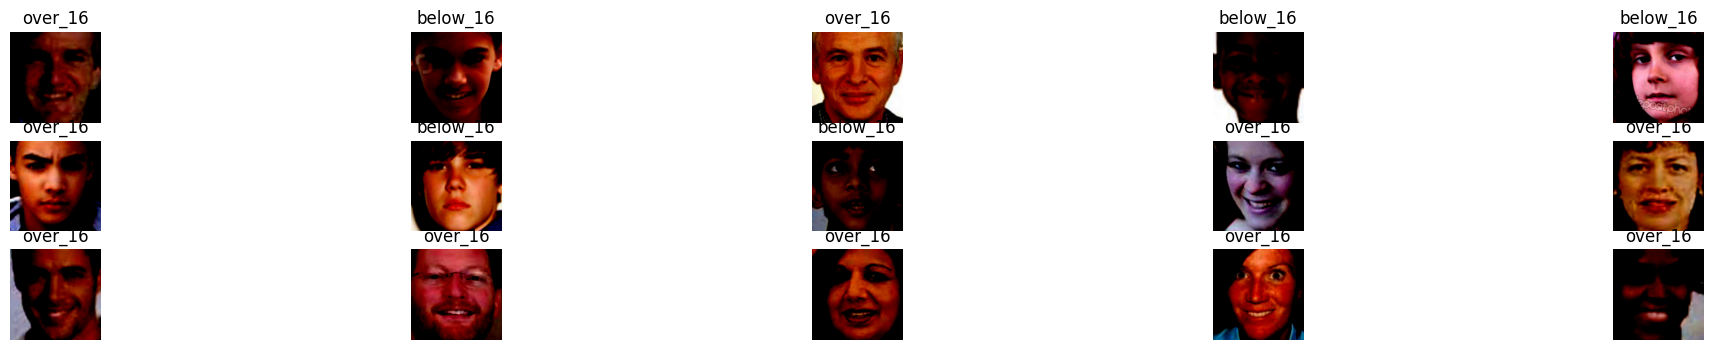

In [ ]:
#visualizing sample data
k = 0
classes = ['below_16', 'over_16']

fig = plt.figure(figsize=(25, 4))

for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    image = image.clip(0,1)
    label = labels[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img

    # Display the image
    ax = fig.add_subplot(3, 5, k+1)
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(classes[label])  # Use label index to get the corresponding class

    k += 1
    if k >= 15:
        break

# Part 2. Baseline Model

In [ ]:
#Convolutional Neural Network Architecture
#My CNN pass the image (3*200*200) to the first conv1 (input:3 output:5 kernel:5)
#Then it goes to the relu function and maxpooling layer(2,2)
#after that it goes to the second conv2 layer(5,10,5)
#and repeat the relu function and the maxpoolung layer, the size becomes(10*53*53)
#There are 7 layers in total, 2 conv layer, 2 maxpooling layer, 2 fully connected layer and 1 output layer
class CNN_MNISTClassifier_1(nn.Module):
    def __init__(self):
        super(CNN_MNISTClassifier_1, self).__init__()
        self.name="CNN"
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(22090, 10)
        self.fc2 = nn.Linear(10, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,22090)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [ ]:
class CNN_MNISTClassifier(nn.Module):
    def __init__(self):
        super(CNN_MNISTClassifier, self).__init__()
        self.name="CNN"
        self.conv1 = nn.Conv2d(3, 5, 7) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(4, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 10) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(17640, 100)
        self.fc2 = nn.Linear(100, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,17640)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [ ]:
 class CNN_MNISTClassifier_2(nn.Module):
    def __init__(self):
        super(CNN_MNISTClassifier_2, self).__init__()
        self.name="CNN"
        self.conv1 = nn.Conv2d(3, 5, 7) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(4, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 10) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(17640, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,17640)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [ ]:
def train(model, train_loader, val_loader, batch_size=32, l_r=0.005, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=l_r, momentum=0.4)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, l_r, epoch)
        torch.save(model.state_dict(), model_path)
        n+=1

        print(("Epoch: {} | Training Accuracy: {} | Validation Accuracy: {}").format(epoch+1, train_acc[epoch], val_acc[epoch]))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def get_accuracy(model,train_loader,val_loader,train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


In [ ]:
def get_test_accuracy(model, data, batch_size):

    data = test_set

    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

### Part (c) Training baseline model

CUDA is available!  Training on GPU ...
Epoch: 1 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 2 | Training Accuracy: 0.7646775745909529 | Validation Accuracy: 0.7427745664739884
Epoch: 3 | Training Accuracy: 0.7925890279114534 | Validation Accuracy: 0.7369942196531792
Epoch: 4 | Training Accuracy: 0.7983638113570741 | Validation Accuracy: 0.7398843930635838
Epoch: 5 | Training Accuracy: 0.8296438883541867 | Validation Accuracy: 0.7861271676300579
Epoch: 6 | Training Accuracy: 0.8666987487969201 | Validation Accuracy: 0.7774566473988439
Epoch: 7 | Training Accuracy: 0.8950914340712224 | Validation Accuracy: 0.8265895953757225
Epoch: 8 | Training Accuracy: 0.8729547641963427 | Validation Accuracy: 0.7832369942196532
Epoch: 9 | Training Accuracy: 0.8753609239653513 | Validation Accuracy: 0.7774566473988439
Epoch: 10 | Training Accuracy: 0.9162656400384985 | Validation Accuracy: 0.8208092485549133
Epoch: 11 | Training Accuracy: 0.9432146294513956

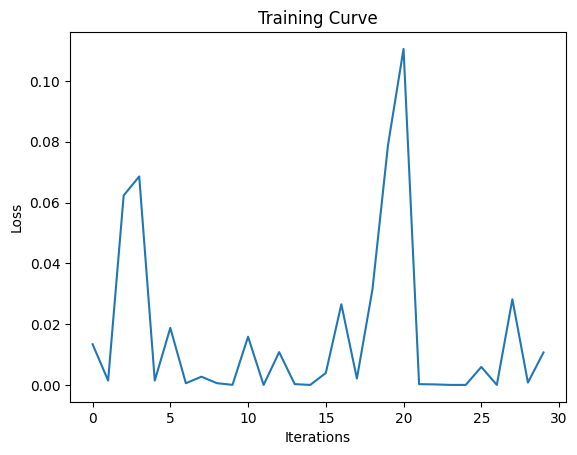

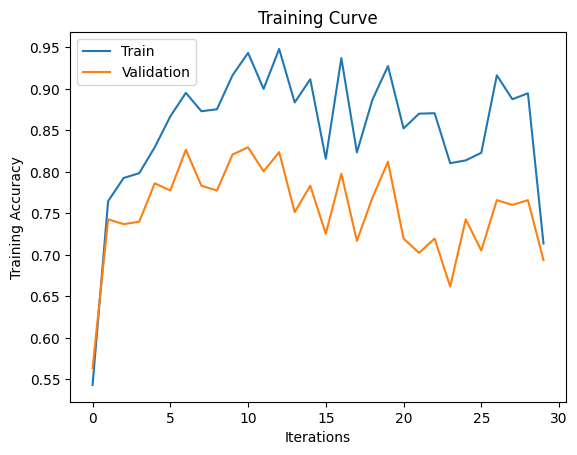

Final Training Accuracy: 0.7136669874879692
Final Validation Accuracy: 0.6936416184971098


In [ ]:
model = CNN_MNISTClassifier_2()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, train_loader, val_loader, num_epochs=30)

CUDA is available!  Training on GPU ...
Epoch: 1 | Training Accuracy: 0.7483156881616939 | Validation Accuracy: 0.6878612716763006
Epoch: 2 | Training Accuracy: 0.7694898941289702 | Validation Accuracy: 0.7398843930635838
Epoch: 3 | Training Accuracy: 0.8108758421559191 | Validation Accuracy: 0.7630057803468208
Epoch: 4 | Training Accuracy: 0.8493743984600578 | Validation Accuracy: 0.7976878612716763
Epoch: 5 | Training Accuracy: 0.8835418671799807 | Validation Accuracy: 0.7976878612716763
Epoch: 6 | Training Accuracy: 0.8320500481231954 | Validation Accuracy: 0.7803468208092486
Epoch: 7 | Training Accuracy: 0.9076034648700674 | Validation Accuracy: 0.7890173410404624
Epoch: 8 | Training Accuracy: 0.917228103946102 | Validation Accuracy: 0.815028901734104
Epoch: 9 | Training Accuracy: 0.8787295476419634 | Validation Accuracy: 0.7687861271676301
Epoch: 10 | Training Accuracy: 0.9307025986525506 | Validation Accuracy: 0.8005780346820809
Epoch: 11 | Training Accuracy: 0.9528392685274302 |

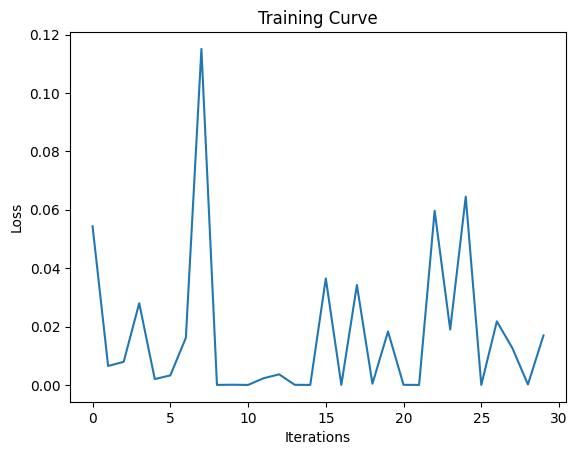

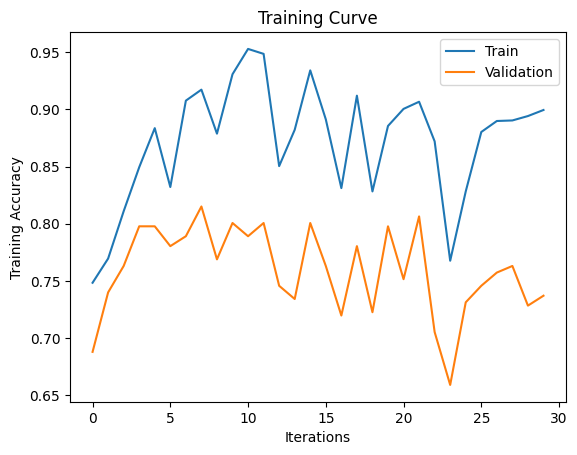

Final Training Accuracy: 0.8994225216554379
Final Validation Accuracy: 0.7369942196531792


In [ ]:
model4 = CNN_MNISTClassifier_2()

if use_cuda and torch.cuda.is_available():
  model4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model4, train_loader, val_loader, num_epochs=30)

In [ ]:
get_test_accuracy(model, test_set, 32)

0.6945244956772334

In [ ]:
get_test_accuracy(model4, test_set, 32)

0.7463976945244957

In [ ]:
model = CNN_MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, train_loader, val_loader, num_epochs=10)

# Part 3. Primary Model

◦ The choice of architecture makes sense for the problem.

◦ The architecture implementation is based on neural networks.

◦ Visual elements are professional, concise and easy to read.

◦ The best results achieved with your model in terms of quantitative (i.e., accuracy, error, loss) and qualitative (i.e., identify something interesting about how your model performs on select samples or class of samples).

◦ Describe any challenges you may have faced with the task.

### Part (a) Architecture (Transfer learning)

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Save Features to Folder (assumes code from 1. has been evaluated)

classes = ['below_16', 'over_16']

# location on Google Drive
alexnet_path = '/content/gdrive/MyDrive/APS360 group project/alexnet_feature'

# define pre-set data
batch_size = 1
num_workers = 1

def get_alexnet_feature(dataset, category):
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
  n = 0
  folder = alexnet_path + '/' + category + '/'

  # save features to folder as tensors
  # the print are for checking how much images are completed in the transformation
  for img, label in loader:
      features = alexnet.features(img)
      features_tensor = torch.from_numpy(features.detach().numpy())
      torch.save(features_tensor.squeeze(0),
                 folder + '/' + str(classes[label]) + '/' + str(classes[label]) + '_' + str(n) + '.tensor')
      n += 1

In [ ]:
get_alexnet_feature(train_set, 'train')
get_alexnet_feature(val_set, 'val')
get_alexnet_feature(test_set, 'test')

In [ ]:
alex_train_folder = "/content/gdrive/MyDrive/APS360 group project/alexnet_feature/train"
alex_val_folder = "/content/gdrive/MyDrive/APS360 group project/alexnet_feature/val"
alex_test_folder = "/content/gdrive/MyDrive/APS360 group project/alexnet_feature/test"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
alex_train_data = torchvision.datasets.DatasetFolder(alex_train_folder, loader=torch.load, extensions=('.tensor'))
alex_val_data = torchvision.datasets.DatasetFolder(alex_val_folder, loader=torch.load, extensions=('.tensor'))
alex_test_data = torchvision.datasets.DatasetFolder(alex_test_folder, loader=torch.load, extensions=('.tensor'))

In [ ]:
alex_train_loader = torch.utils.data.DataLoader(alex_train_data, batch_size=1, shuffle=True)
alex_val_loader = torch.utils.data.DataLoader(alex_val_data, batch_size=1, shuffle=True)
alex_test_loader = torch.utils.data.DataLoader(alex_test_data, batch_size=1, shuffle=True)

In [ ]:
for img, label in alex_train_loader:
    print("Data type of img:", type(img))
    print("Data size of img:", img.size())
    print("Data type of label:", type(label))
    print("Data type of img tensor elements:", img.dtype)
    break

len(alex_train_loader)

Then, we'll build a classifer to process the feature extracted by alexnet

In [ ]:
class Alexnet_features(nn.Module):

      def __init__(self):
          self.name = "CNN_features"
          super(Alexnet_features, self).__init__()
          self.fc1 = nn.Linear(256*5*5, 1024)
          self.fc2 = nn.Linear(1024, 512)
          self.fc3 = nn.Linear(512,128)
          self.fc4 = nn.Linear(128,53)
      def forward(self, x):
          x = x.view(-1,256*5*5)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = F.relu(self.fc3(x))
          x = F.softmax(self.fc4(x))
          return x

In [ ]:
class primary_CNN_features(nn.Module):
  def __init__(self):
        self.name='CNN'
        super(primary_CNN_features, self).__init__()
        self.conv1 = nn.Conv2d(3,16,7) # in_channels, out_chanels, kernel_size  # Stride defalt to be 1, padding 0
        self.conv2 = nn.Conv2d(16,32,5)
        self.conv3 = nn.Conv2d(32, 50,3)
        self.conv4 = nn.Conv2d(50,86,3)
        self.conv5 = nn.Conv2d(86, 100,2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(67712, 1280)
        self.fc2 = nn.Linear(1280, 320)
        self.fc3 = nn.Linear(320, 4)

  def forward(self, img):
      x = self.pool(F.relu(self.conv1(img)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 67712)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
class primary_CNN_features_1(nn.Module):
  def __init__(self):
        self.name='CNN'
        super(primary_CNN_features_1, self).__init__()
        self.conv1 = nn.Conv2d(3,16,7) # in_channels, out_chanels, kernel_size  # Stride defalt to be 1, padding 0
        self.conv2 = nn.Conv2d(16,32,5)
        self.conv3 = nn.Conv2d(32, 50,3)
        self.conv4 = nn.Conv2d(50,86,3)
        self.conv5 = nn.Conv2d(86, 100,2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(168100, 1280)
        self.fc2 = nn.Linear(1280, 320)
        self.fc3 = nn.Linear(320, 2)

  def forward(self, img):
      x = self.pool(F.relu(self.conv1(img)))
      x = self.pool(F.relu(self.conv2(x)))
      x= F.relu(self.conv3(x))
      x= F.relu(self.conv4(x))
      x= F.relu(self.conv5(x))
      x = x.view(-1, 168100)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

### Part (b) Functions

In [ ]:
model_1 = primary_CNN_features_1()

if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


train(model_1, train_loader, val_loader, l_r=1e-4,num_epochs=30)

CUDA is available!  Training on GPU ...
Epoch: 1 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 2 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 3 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 4 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 5 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 6 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 7 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 8 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 9 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 10 | Training Accuracy: 0.5433108758421559 | Validation Accuracy: 0.5635838150289018
Epoch: 11 | Training Accuracy: 0.5433108758421559

CUDA is available!  Training on GPU ...
Epoch: 1 | Training Accuracy: 0.5437921077959577 | Validation Accuracy: 0.5635838150289018
Epoch: 2 | Training Accuracy: 0.6506256015399422 | Validation Accuracy: 0.6069364161849711
Epoch: 3 | Training Accuracy: 0.6698748796920115 | Validation Accuracy: 0.6213872832369942
Epoch: 4 | Training Accuracy: 0.6891241578440809 | Validation Accuracy: 0.684971098265896
Epoch: 5 | Training Accuracy: 0.7478344562078922 | Validation Accuracy: 0.7109826589595376
Epoch: 6 | Training Accuracy: 0.7670837343599615 | Validation Accuracy: 0.7456647398843931
Epoch: 7 | Training Accuracy: 0.7988450433108758 | Validation Accuracy: 0.7543352601156069
Epoch: 8 | Training Accuracy: 0.7872954764196343 | Validation Accuracy: 0.7398843930635838
Epoch: 9 | Training Accuracy: 0.8358999037536092 | Validation Accuracy: 0.7832369942196532
Epoch: 10 | Training Accuracy: 0.8325312800769971 | Validation Accuracy: 0.7890173410404624
Epoch: 11 | Training Accuracy: 0.8156881616939364 

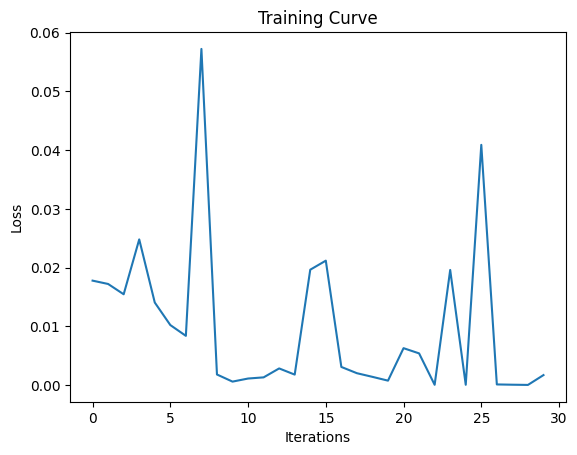

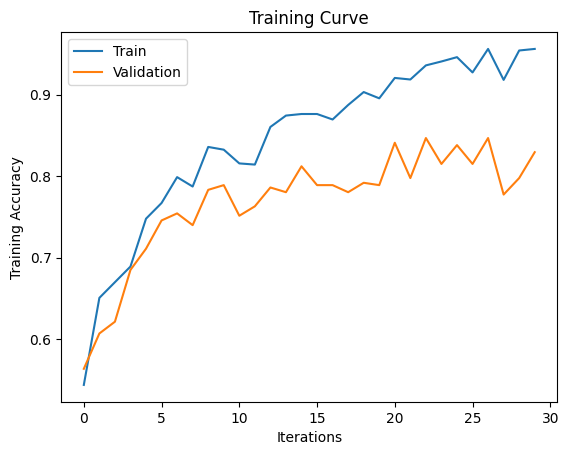

Final Training Accuracy: 0.9562078922040423
Final Validation Accuracy: 0.8294797687861272


In [ ]:
model_5 = primary_CNN_features_1()

if use_cuda and torch.cuda.is_available():
  model_5.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


train(model_5, train_loader, val_loader, l_r=1e-4,num_epochs=30)

In [ ]:
def get_test_accuracy(model, data, batch_size):

    data = test_set

    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
get_test_accuracy(model_1, test_set, 64)

0.8011527377521613

In [ ]:
get_test_accuracy(model_5, test_set, 32)

0.8040345821325648

### Part (c) Training

In [ ]:
model_2 = Alexnet_features()

if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


train(model_2, alex_test_loader, alex_val_loader, l_r=1e-4, num_epochs=30)

CUDA is available!  Training on GPU ...


RuntimeError: ignored